In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix, hstack

## Reading Dataset

In [2]:
path = r"datasets/spam.csv"


spam_data = pd.read_csv(path)

spam_data['target'] = np.where(spam_data['target']=='spam',1,0)
spam_data.head(10)

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
5,FreeMsg Hey there darling it's been 3 week's n...,1
6,Even my brother is not like to speak with me. ...,0
7,As per your request 'Melle Melle (Oru Minnamin...,0
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1


<AxesSubplot:>

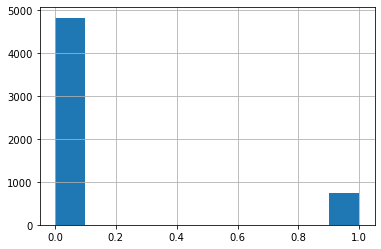

In [3]:
# checking the distribbution of targets
spam_data['target'].hist()

In [4]:
# We can see from the distribution that the dataset is skewed so we will be 
# using roc_auc as evaluation metric for the model.

In [5]:
#splitting the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], 
                                                    spam_data['target'], 
                                                    random_state=0)

In [6]:
# Utility Function to add feature to given dataset
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

## Feature Engineering

In [7]:
# count the number of digit present in each document of the train data
digit_count_train = (X_train.str.extractall('(\d+)').reset_index()
           .drop(columns = 'match').set_index('level_0')
           .groupby(by = 'level_0').sum()[0].apply(lambda x: len(x)))

digit_count_train = pd.DataFrame(X_train).join(pd.DataFrame(digit_count_train),how = 'left').fillna(value = 0)[0]
digit_count_train

872      0.0
831      2.0
1273     5.0
3314    14.0
4929     0.0
        ... 
4931     1.0
3264    33.0
1653     0.0
2607     0.0
2732     0.0
Name: 0, Length: 4179, dtype: float64

In [8]:
# length of the document present in training dataset
length_of_doc_train = X_train.apply(lambda x: len(list(x)))
length_of_doc_train

872      31
831     130
1273     66
3314    146
4929    124
       ... 
4931     37
3264    173
1653    147
2607     62
2732     82
Name: text, Length: 4179, dtype: int64

In [9]:
# number of now-word character in a document
non_word_char_count_train = (X_train.str.extractall('([^\w_])').
                           reset_index().drop(columns = 'match').
                           set_index('level_0').groupby(by = 'level_0').
                           sum()[0].apply(lambda x: len(x)))
non_word_char_count_train = pd.DataFrame(X_train).join(pd.DataFrame(non_word_char_count_train),how = 'left').fillna(value = 0)[0]
non_word_char_count_train

872      8.0
831     29.0
1273    16.0
3314    26.0
4929    26.0
        ... 
4931    12.0
3264    34.0
1653    47.0
2607    18.0
2732    21.0
Name: 0, Length: 4179, dtype: float64

In [10]:
# count the number of digit present in each document of the test data
digit_count_test = (X_test.str.extractall('(\d+)').reset_index()
           .drop(columns = 'match').set_index('level_0')
           .groupby(by = 'level_0').sum()[0].apply(lambda x: len(x)))
digit_count_test = pd.DataFrame(X_test).join(pd.DataFrame(digit_count_test),how = 'left').fillna(value = 0)[0]
digit_count_test

4456     0.0
690      0.0
944      0.0
3768     1.0
1189     0.0
        ... 
1889     1.0
2250     0.0
2915     0.0
1282     0.0
1206    10.0
Name: 0, Length: 1393, dtype: float64

In [11]:
# number of now-word character in a document
non_word_char_count_test = (X_test.str.extractall('([^\w_])').
                           reset_index().drop(columns = 'match').
                           set_index('level_0').groupby(by = 'level_0').
                           sum()[0].apply(lambda x: len(x)))
non_word_char_count_test = pd.DataFrame(X_test).join(pd.DataFrame(non_word_char_count_test),how = 'left').fillna(value = 0)[0]
non_word_char_count_test

4456    10.0
690      4.0
944     46.0
3768    23.0
1189    11.0
        ... 
1889     8.0
2250    20.0
2915    10.0
1282    47.0
1206    36.0
Name: 0, Length: 1393, dtype: float64

In [12]:
# length of the document present in test dataset
length_of_doc_test = X_test.apply(lambda x: len(list(x)))
length_of_doc_test

4456     50
690      18
944     221
3768     96
1189     49
       ... 
1889     32
2250    113
2915     47
1282    160
1206    148
Name: text, Length: 1393, dtype: int64

## Data Preprocessing and Model Selection

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report

In [14]:
# preparing training data
vec= CountVectorizer(min_df= 5,ngram_range=(2,5),analyzer='char_wb')
X_train_vec= vec.fit_transform(X_train)
X_train_vec = add_feature(X_train_vec,length_of_doc_train)
X_train_vec = add_feature(X_train_vec,digit_count_train)
X_train_vec = add_feature(X_train_vec,non_word_char_count_train)

In [15]:
# Preparing test data
X_test_vec= vec.transform(X_test)
X_test_vec = add_feature(X_test_vec,length_of_doc_test)
X_test_vec = add_feature(X_test_vec,digit_count_test)
X_test_vec = add_feature(X_test_vec,non_word_char_count_test)

In [16]:
clf = [(LogisticRegression(),{'penalty':['l1','l2'],'C':[0.01,0.1,1,10,100]}),
       (MultinomialNB(),{'alpha': [0.01,0.1,1,10,100]}),
       (SVC(),{'C':[0.01,0.1,1,10,100, 500, 1000, 10000]})]

In [17]:
b_score = []

for i in clf:
    g=GridSearchCV(i[0],param_grid=i[1],cv= 5)
    g.fit(X_train_vec,y_train)
    b_score.append((g.best_score_,g.best_params_))

/home/ketan/miniconda3/envs/Project4/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/ketan/miniconda3/envs/Project4/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

/home/ketan/miniconda3/envs/Project4/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/ketan/miniconda3/envs/Project4/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

In [18]:
b_score

[(0.9904289029596309, {'C': 100, 'penalty': 'l2'}),
 (0.9861226828639372, {'alpha': 0.1}),
 (0.9894719651605879, {'C': 500})]

## Evaluation of Selected Model on Test Data

In [19]:
clf = LogisticRegression(C=100, penalty='l2')
clf.fit(X_train_vec,y_train)
y_pred = clf.predict(X_test_vec)

/home/ketan/miniconda3/envs/Project4/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [20]:
print('Accuracy: {}\n'.format(clf.score(X_test_vec,y_test)))
print('ROC_AUC_Score: {}\n'.format(roc_auc_score(y_test, y_pred)))
print('Confusion_matrix:\n{}\n'.format(confusion_matrix(y_test,y_pred)))
print('Classification_report:\n\n{}'.format(classification_report(y_test,y_pred)))

Accuracy: 0.9935391241923905

ROC_AUC_Score: 0.9813973821367333

Confusion_matrix:
[[1194    2]
 [   7  190]]

Classification_report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1196
           1       0.99      0.96      0.98       197

    accuracy                           0.99      1393
   macro avg       0.99      0.98      0.99      1393
weighted avg       0.99      0.99      0.99      1393

